## Import Data

In [1]:
import gzip
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from collections import Counter

In [4]:
DATA_PATH = os.path.join("data", "processed", "phoenixweather2014t")

try:
    with gzip.open(os.path.join(DATA_PATH, 'phoenix14t.pami0.train.annotations_only.gzip'), "rb") as f:
        annotations = pickle.load(f)
except:
    print("Error: Invalid path")

### Convert to Pandas DataFrame

In [5]:
VIDEO_PATH = os.path.join(DATA_PATH, "videos_phoenix", "videos")
names = list(
    map(
        lambda x: os.path.join(VIDEO_PATH, *x.split("/")) + ".mp4",
        [key["name"] for key in annotations],
    )
)
glosses = [key["gloss"] for key in annotations]
texts = [key["text"] for key in annotations]

data = {"names": names, "glosses": glosses, "texts": texts}

df = pd.DataFrame(data)


In [21]:
df.shape

(7096, 3)

In [22]:
df.head()

,names,glosses,texts
0,data\processed\phoenixweather2014t\videos_phoe...,JETZT WETTER MORGEN DONNERSTAG ZWOELF FEBRUAR,und nun die wettervorhersage für morgen donner...
1,data\processed\phoenixweather2014t\videos_phoe...,ORT REGEN DURCH REGEN KOENNEN UEBERSCHWEMMUNG ...,mancherorts regnet es auch länger und ergiebig...
2,data\processed\phoenixweather2014t\videos_phoe...,NORDWEST HEUTE NACHT TROCKEN BLEIBEN SUEDWEST ...,im nordwesten bleibt es heute nacht meist troc...
3,data\processed\phoenixweather2014t\videos_phoe...,TAGSUEBER OFT REGEN GEWITTER KOENNEN MANCHMAL ...,auch am tag gibt es verbreitet zum teil kräfti...
4,data\processed\phoenixweather2014t\videos_phoe...,WOLKE LOCH SPEZIELL NORDWEST,größere wolkenlücken finden sich vor allem im ...


In [23]:
df.tail()

,names,glosses,texts
7091,data\processed\phoenixweather2014t\videos_phoe...,DIENSTAG WIND STARK REGEN KOMMEN,am dienstag wird es sehr windig und es regnet ...
7092,data\processed\phoenixweather2014t\videos_phoe...,MITTWOCH WIND MEHR REGEN,am mittwoch legt der wind noch zu und es regne...
7093,data\processed\phoenixweather2014t\videos_phoe...,SUED REGION SONNE AUCH DABEI,im süden zeigt sich aber auch die sonne .
7094,data\processed\phoenixweather2014t\videos_phoe...,DONNERSTAG FREUNDLICH SONNE DANN SPAETER KOMME...,der donnerstag beginnt oft freundlich später z...
7095,data\processed\phoenixweather2014t\videos_phoe...,BLEIBEN WIND,es bleibt windig .


In [6]:
df.describe()

,names,glosses,texts
count,7096,7096,7096
unique,7096,6900,6853
top,data\processed\phoenixweather2014t\videos_phoe...,SCHOEN ABEND TSCHUESS,guten abend liebe zuschauer .
freq,1,22,63


# Univariate Analysis

Creating lists with length of glosses sequences, length of German sentences, and number of frames respectively.

In [10]:
def with_opencv(filename):
    video = cv2.VideoCapture(filename)
    frame_count = video.get(cv2.CAP_PROP_FRAME_COUNT)

    return frame_count

gloss_lengths = list(map(lambda x: len(x.split()), list(df['glosses'])))
text_lengths = list(map(lambda x: len(x.split()), list(df['texts'])))
frames = list(map(lambda x: with_opencv(x), list(df['names'])))

Descriptive statistics about each list

In [11]:
gloss_df = pd.DataFrame(gloss_lengths).rename(columns={0: 'Gloss Lengths'})
text_df = pd.DataFrame(text_lengths).rename(columns={0: 'Text Lengths'})
frame_df = pd.DataFrame(frames).rename(columns={0: 'Frames'})

display(gloss_df.describe(include='all'))
display(text_df.describe(include='all'))
display(frame_df.describe(include='all'))

,Gloss Lengths
count,7096.000000
mean,7.785654
std,3.436425
min,1.000000
25%,5.000000
50%,7.000000
75%,10.000000
max,30.000000


,Text Lengths
count,7096.000000
mean,14.962937
std,5.983502
min,2.000000
25%,11.000000
50%,14.000000
75%,18.000000
max,53.000000


,Frames
count,7096.000000
mean,116.594419
std,49.859426
min,16.000000
25%,83.000000
50%,112.000000
75%,144.000000
max,475.000000


Histogram

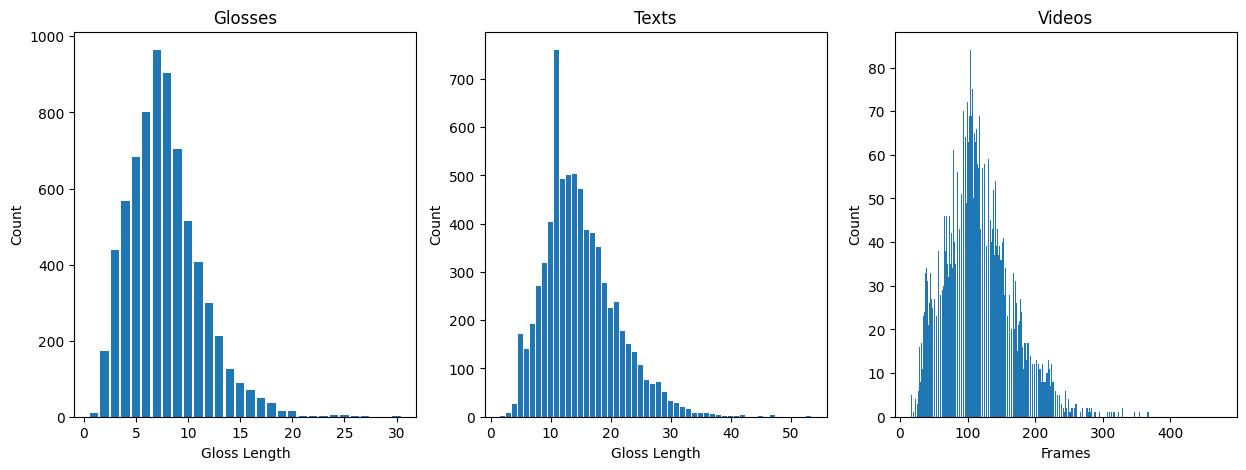

In [12]:
fig, axis = plt.subplots(1, 3, figsize=(15, 5))

gloss_count = Counter(gloss_lengths)
text_count = Counter(text_lengths)
frame_count = Counter(frames)

axis[0].bar(gloss_count.keys(), gloss_count.values())
axis[0].set_title('Glosses')
axis[0].set_xlabel("Gloss Length")
axis[0].set_ylabel("Count")

axis[1].bar(text_count.keys(), text_count.values())
axis[1].set_title('Texts')
axis[1].set_xlabel("Gloss Length")
axis[1].set_ylabel("Count")

axis[2].bar(frame_count.keys(), frame_count.values())
axis[2].set_title('Videos')
axis[2].set_xlabel("Frames")
axis[2].set_ylabel("Count")
plt.show()

Boxplot

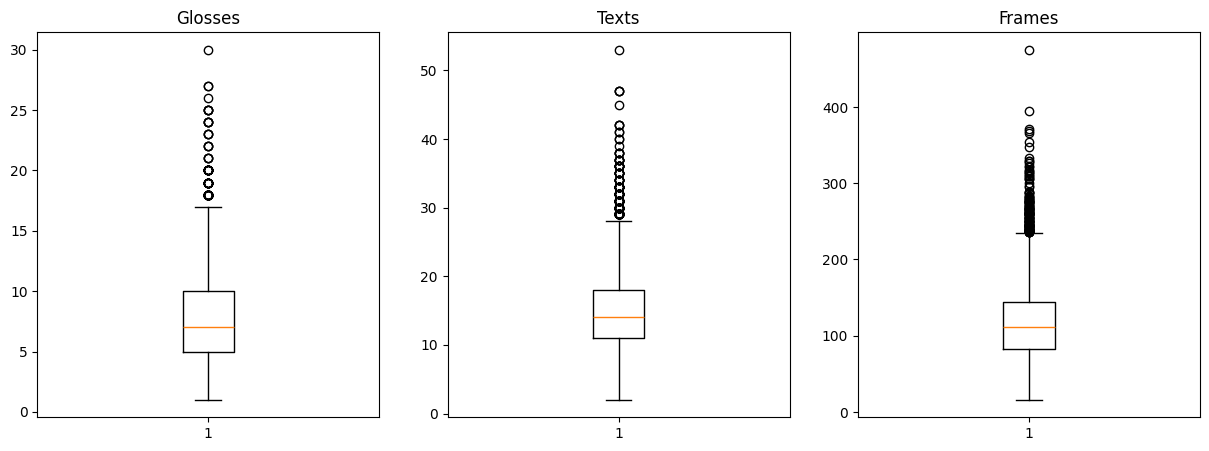

In [20]:
fig, axis = plt.subplots(1, 3, figsize=(15, 5))

axis[0].boxplot(gloss_lengths)
axis[0].set_title("Glosses")

axis[1].boxplot(text_lengths)
axis[1].set_title("Texts")

axis[2].boxplot(frames)
axis[2].set_title("Frames")

plt.show()

# Multivariate Analysis

Correlation Matrix

In [18]:
corr_df = pd.DataFrame({'gloss_length': gloss_lengths, 'sentence_length': text_lengths, 'frames': frames})
corr = corr_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,gloss_length,sentence_length,frames
gloss_length,1.000000,0.789084,0.856894
sentence_length,0.789084,1.000000,0.854542
frames,0.856894,0.854542,1.000000
